In [1]:
pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

np.random.seed(0)
n = 10000
x = np.linspace(0, 20, n)
y = x ** 3/20 - x**2 - x + 10 * np.random.randn(n)

# Create traing, test data and targets

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 0)

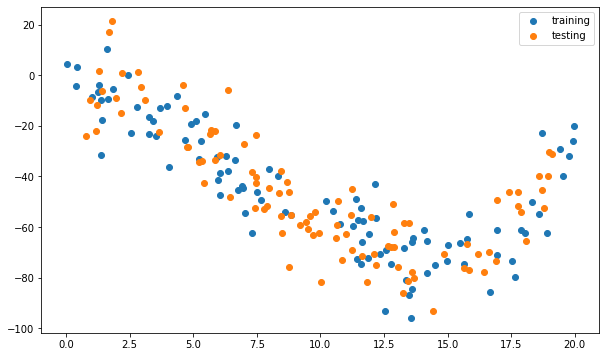

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.scatter(X_train[:100], y_train[:100], label = "training") # create a scatter of first 100 values
ax.scatter(X_test [:100], y_test[:100], label = "testing") 

ax.legend()

del fig, ax

In [4]:
nn.Module?

In [5]:
# All NN needs to have basic class from nn.Module.  We will overwrite some of these
# __init__ and will overwrite __forward__ method. 
import torch
import torch.nn as nn


class DNNRegressor(nn.Module):
    
    # Activation Functions
    act_fns = {"relu" : nn.ReLU(), "sigmoid": nn.Sigmoid(), "tanh": nn.Tanh()}
    
    # Define basic architecture , how many layers, how many hidden layers, fully connected layers (aka Linear layers)
    # attributes of our class, build NN attach modules to our class, and the modules will be the 
    # attributes of the class
    def __init__(self, in_dim, out_dim, hid_dims, act_fn = "relu", dropout_prob = 0.1):
        # Dont need the Module attribute in Super() - for compatibility for Python 2
        super().__init__()
        
        if isinstance(hid_dims, int):
            hid_dims = (hid_dims,)
            
        if not isinstance(hid_dims, tuple):
            raise ValueError("hid_dims must be a tuple. ")
        
        # Design the input and hidden and output layers...three attributes for these layers 
        # fc == fully connected
        # Input layer (one linear layer) - the first layer not the X data.  You have X data --> Input layer
        # --> Hidden Layer --> Output Layer
        self.input_fc = nn.Sequential( # concatenats all modules it receives as input, behaves as one
            #single giant module.  (nn. Relu, etc, Linear, Dropout modules)
            nn.Linear(in_features = in_dim, out_features = hid_dims[0] if hid_dims else out_dim), 
            DNNRegressor.act_fns[act_fn], # activation functions, popular is ReLU
            nn.Dropout(dropout_prob) # Regularization method (using dropout here - to randomly turn off some 
            # neurons here, output of that neuron will be set of 0)
        )
        
        # self.input_act_fn = # pass in some activation funciton, but not an elegant way to do this
        
        # Hidden Layers
        self.hid_fc = nn.ModuleList() # python list nn.ModuleList() of layers, can append with it, etc
        for index in range(len(hid_dims) - 1):
            self.hid_fc.append(
                nn.Sequential( #append a module to the module list (all the modules - activations, linear, dropout)
                    nn.Linear(in_features = hid_dims[index], out_features = hid_dims[index + 1]), #index + 1 bc the 
                    # outfeatures will need to be the next item in the list (if in_feature/layer is a 3 (the in 
                    # layer has 3 features, the out_layer has 4 output features), then out_feature is a 4)
                    DNNRegressor.act_fns[act_fn],
                    nn.Dropout(dropout_prob)
                )
            )
        
        self.hid_fc = nn.Sequential(*self.hid_fc) # Single module by passing list into the nn.Sequential module
        # * means to expand the list and pass the items of the list as input into the nn.Sequential.  Condense all
        # the hidden layers into this one variable
        
        # Output layer (one linear layer) - no activation or dropout with correct # of inputs and outputs
        self.output_fc = nn.Linear(in_features = hid_dims[-1], out_features=out_dim) # output layer is described
        # by two values, the input layer # features to the output layer, and then the final output layer # of features
        
    def forward(self, x): # mini-batch (N, D)  D = data dimensions
        input_fc_out = self.input_fc(x) #pass input into the Input Layer_fc 
        hid_fc_out = self.hid_fc(input_fc_out) #pass input layer to hidden layer
        output_fc_out = self.output_fc(hid_fc_out) #then pass hidden layer to output layer
        return output_fc_out
        
    
    
    
    

In [6]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch
import math

# https://scikit-learn.org/stable/developers/develop.html

class NeuralRegressor(BaseEstimator): #compatible with sklearn, sklearn regressor has fit function, and predict and
    #score function, it is an estimator in sklearn, will be able to do a gridsearch. Organizes code nicely using
    # this compatibility. Using framework with sklearn - still is in pytorch but can use the def fit, def predict, def
    # score.  Overrides some from sklearn methods.  Creating an estimator
    
    loss_fns = {"mse": nn.MSELoss(), "mae": nn.L1Loss()}
    
    def __init__(self, hid_dims = (100,), act_fn = "relu", dropout_prob = 0.01,
                 batch_size = 64, lr = 1e-3, num_epochs = 5, loss_fn = "mse", random_state = None):
        self.hid_dims = hid_dims
        self.act_fn = act_fn
        self.dropout_prob = dropout_prob
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.loss_fn = NeuralRegressor.loss_fns[loss_fn]
        self.random_state = random_state
        #self.model = None
        
        
        
        
        
    # want to fit the DNNRegressor - this overrides the baseestimator fit function   
    def fit(self, X, y):
        
        
        """A reference implementation of a fitting function.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
            
        X, y = check_X_y(X, y, accept_sparse = False)
        y = y.reshape(X.shape[0], -1)
        
        in_dim, out_dim = X.shape[-1], y.shape[-1]
        
        # set random state
        if self.random_state is not None:
            torch.manual_seed(self.random_state)
            
        #convert np.ndarray to torch.tensor, cannot work with np array from there on out, but tensors are similar
        # to ndarray, tensor has a grad attribute, records the gradient for backprop, also tensors can run on GPUs
        # this is an efficient operation, needs to cast to float
        X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
        
        
        """#dataset, dataloader, figure out device, create model, put on correct device, set to train mode, initialize
        # optimizer that takes in the models params as input. then will need a learning rate scheduler (optional)"""
        
        #wrap data in dataloader - we dont want to give the entire dataset to the model to train, need to send in 
        # mini batches, pytorch provides this functionality for us called DataLoader (takes in the dataset - like a 
        # list (TensorDataset - takes in some batched tensor for X and y and arrange in appropriate manner)) 
        dataset = TensorDataset(X, y)#(7000, 1)(7000, 1) #first value is the batches, second is the data ? something?
        # dataset[0] returns a tuple of the first row of X and the first row of y - will be a tensor with one value
        # for each X and y
        
        #DataLoader takes the dataset and batch size, shuffles data, num_workers == cpu to fetch data and batch it
        #pin_memory is a GPU optimization - will want to move data onto GPU - faster transfer from memory to GPU memory
        dataloader = DataLoader(dataset, batch_size = self.batch_size, shuffle = True, num_workers = 4, pin_memory = True)
        
        # device-agnostic, works with both cpu and cuda - will run on either cuda or cpu - this should cover it
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        #create the DL model,- move this model to which ever device we have (cuda (GPU) or cpu), 
        #then set model into training mode. 
        self.model_ = DNNRegressor(in_dim, out_dim, self.hid_dims, self.act_fn, self.dropout_prob).to(device).train()
        
        #only create optimizer only after the model is created and put onto the correct device, take in a learning rate
        optimizer = optim.Adam(self.model_.parameters(), lr = self.lr) #learning rate or can specify others like momentum
        
        # Training loop - train this model for some number of epochs
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            # extract data from dataloader - will get inputs and label tuple
            for inputs, labels in dataloader: #input and labels are tensors (batch tensors)
                # move data to correct device - same as the model
                inputs = inputs.to(device)
                loss = labels.to(device)
                
                # makes predictions and compute the loss - pass inputs into our model and get the outputs
                outputs = self.model_(inputs) #pass input into model
                loss = self.loss_fn(outputs, labels) # based on outputs (and true labels) we can calculate mean batch loss (single number) 
                
                #backpropagation
                optimizer.zero_grad() # clears existing gradient - otherwise will be accumulated bc we
                #want to update the model after each mini batch of data has been consumed. 
                loss.backward() #calculate gradient of each
                
                #update the weights parameters of module, using gradients, update the parameters along direction
                # of the gradient (gradien descent)
                optimizer.step() 
                
                #optional: record the loss - tracking training progress 
                # loss of current mini-batch then accumulating to get the total loss
                epoch_loss += loss.item() *len(inputs) #convert average loss by the sum of the loss, accumulate teh sum of the loss over the all the batches
                
            # then this is the average loss calculation across entire training set
            epoch_loss /= X.shape[0]
            # MRSE more informative loss calculation
            if isinstance(self.loss_fn, nn.MSELoss): #training use the square loss bc gradient is nice
                epoch_loss = math.sqrt(epoch_loss) #to calculate the RMSE
            print(f"Epoch {epoch}: Avg train loss = {epoch_loss}")
            
            
        # self.is_fitted = True
        # 'fit' should always return 'self'
        return self
        
        
        
        
        
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        Returns
        -------
        y : ndarray, shape (n_samples, n_outputs)
            The predicted target values (class labels in classification, real numbers in
            regression).
        """
        X = check_array(X, accept_sparse = False)
        check_is_fitted(self, 'model_')
        
        X = torch.from_numpy(X).float()
        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size = self.batch_size, shuffle = False, num_workers = 4, pin_memory = True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # move the model to the correct device and set it to evaulation mode
        self.model_ = self.model_.to(device).eval()
        
        all_outputs = []
        with torch.no_grad(): # ask pytorch not to record gradient - save memory
            for inputs, *_ in dataloader:
                inputs = inputs.to(device)
                outputs = self.model_(inputs)
                all_outputs.append(outputs)
                
        all_outputs = torch.cat(all_outputs, dim = 0)
        return all_outputs
    
    

    
    
    
    def score(self, X, y):
        """A reference implementation of a scoring function.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The test input samples.
        y : array-like, shape (n_samples,) or (n_samples, n_outputs)
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        loss : float
            Returns RMSE if self.loss_fn == "mse". Returns MAE if self.loss_fn == "mae".
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        y = y.reshape(X.shape[0], -1)
        check_is_fitted(self, 'model_')

        X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False, num_workers=4, pin_memory=True)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # move the model to the correct device and set it to evaluation mode
        self._model = self.model_.to(device).eval()

        total_loss = 0.0
        with torch.no_grad(): # ask Pytorch not to record grad - save memory
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model_(inputs)
                loss = self.loss_fn(outputs, labels)
                total_loss += loss.item() * len(inputs)
        
        total_loss /= X.shape[0]
        if isinstance(self.loss_fn, nn.MSELoss):
            total_loss = math.sqrt(total_loss)
        return total_loss

    # def get_params(self, deep=True):
    #     # suppose this estimator has parameters "alpha" and "recursive"
    #     return {"alpha": self.alpha, "recursive": self.recursive}

    # def set_params(self, **parameters):
    #     for parameter, value in parameters.items():
    #         setattr(self, parameter, value)
    #     return self

In [8]:
from sklearn.utils.estimator_checks import check_estimator

neural_reg = NeuralRegressor(batch_size=32, num_epochs=50, random_state=42)
neural_reg.fit(X_train.reshape(-1, 1), y_train)
# check_estimator(neural_reg)

Epoch 0: Avg train loss = 25.987165909667826
Epoch 1: Avg train loss = 20.404742276964022
Epoch 2: Avg train loss = 20.241738553573505
Epoch 3: Avg train loss = 20.02862388003716
Epoch 4: Avg train loss = 19.843195584856794
Epoch 5: Avg train loss = 19.54452226173495
Epoch 6: Avg train loss = 19.252447179723422
Epoch 7: Avg train loss = 18.97515642305214
Epoch 8: Avg train loss = 18.626460327957062
Epoch 9: Avg train loss = 18.253549670843135
Epoch 10: Avg train loss = 17.88692588759548
Epoch 11: Avg train loss = 17.47614295614733
Epoch 12: Avg train loss = 17.063789841738583
Epoch 13: Avg train loss = 16.650252852985727
Epoch 14: Avg train loss = 16.27266420290226
Epoch 15: Avg train loss = 15.928888789339672
Epoch 16: Avg train loss = 15.578485864363453
Epoch 17: Avg train loss = 15.171211648195703
Epoch 18: Avg train loss = 14.852119448408093
Epoch 19: Avg train loss = 14.545130504845764
Epoch 20: Avg train loss = 14.247887290130391
Epoch 21: Avg train loss = 14.03824149339539
Epoch

NeuralRegressor(batch_size=32, loss_fn=MSELoss(), num_epochs=50,
                random_state=42)

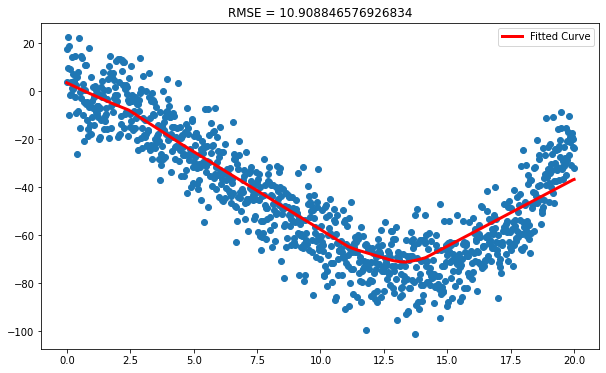

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

np.random.seed(0)
x = np.linspace(0, 20, 1000)  # x is drawn from a fixed range
y = x ** 3 / 20 - x ** 2 - x + 10 * np.random.randn(1000)

ax.scatter(x, y)

y_pred = neural_reg.predict(x.reshape(-1, 1)).cpu().numpy().flatten() # ypredict is still in a batch, so need to flatten, flatten puts X and y-pred into the right shape
ax.plot(x, y_pred, color="r", linewidth=3, label="Fitted Curve")
rmse = np.sqrt(np.mean((y - y_pred) ** 2))
ax.set_title(f"RMSE = {rmse}")
#piece wise linear function 
ax.legend()

In [10]:
neural_reg.score(x.reshape(-1, 1), y)

10.908846513310953

In [ ]:
# from sklearn.model_selection import GridSearchCV

# clf = GridSearchCV(NeuralRegressor(), {"batch_size":(32, 64, 128)}, safe=False)
# clf.fit(X_train.reshape(-1, 1), y_train)